# 1. Introuction

 This notebook outlines the creation, compilation, and training of a [Hierarchical Vision Transformer](https://github.com/microsoft/Swin-Transformer) network to classify 101 types of food. This model uses shifted windows (Swin), bringing greater efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connection.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sat Jan 18 16:45:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   55C    P8             13W /  200W |    1427MiB /  12282MiB |      7%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

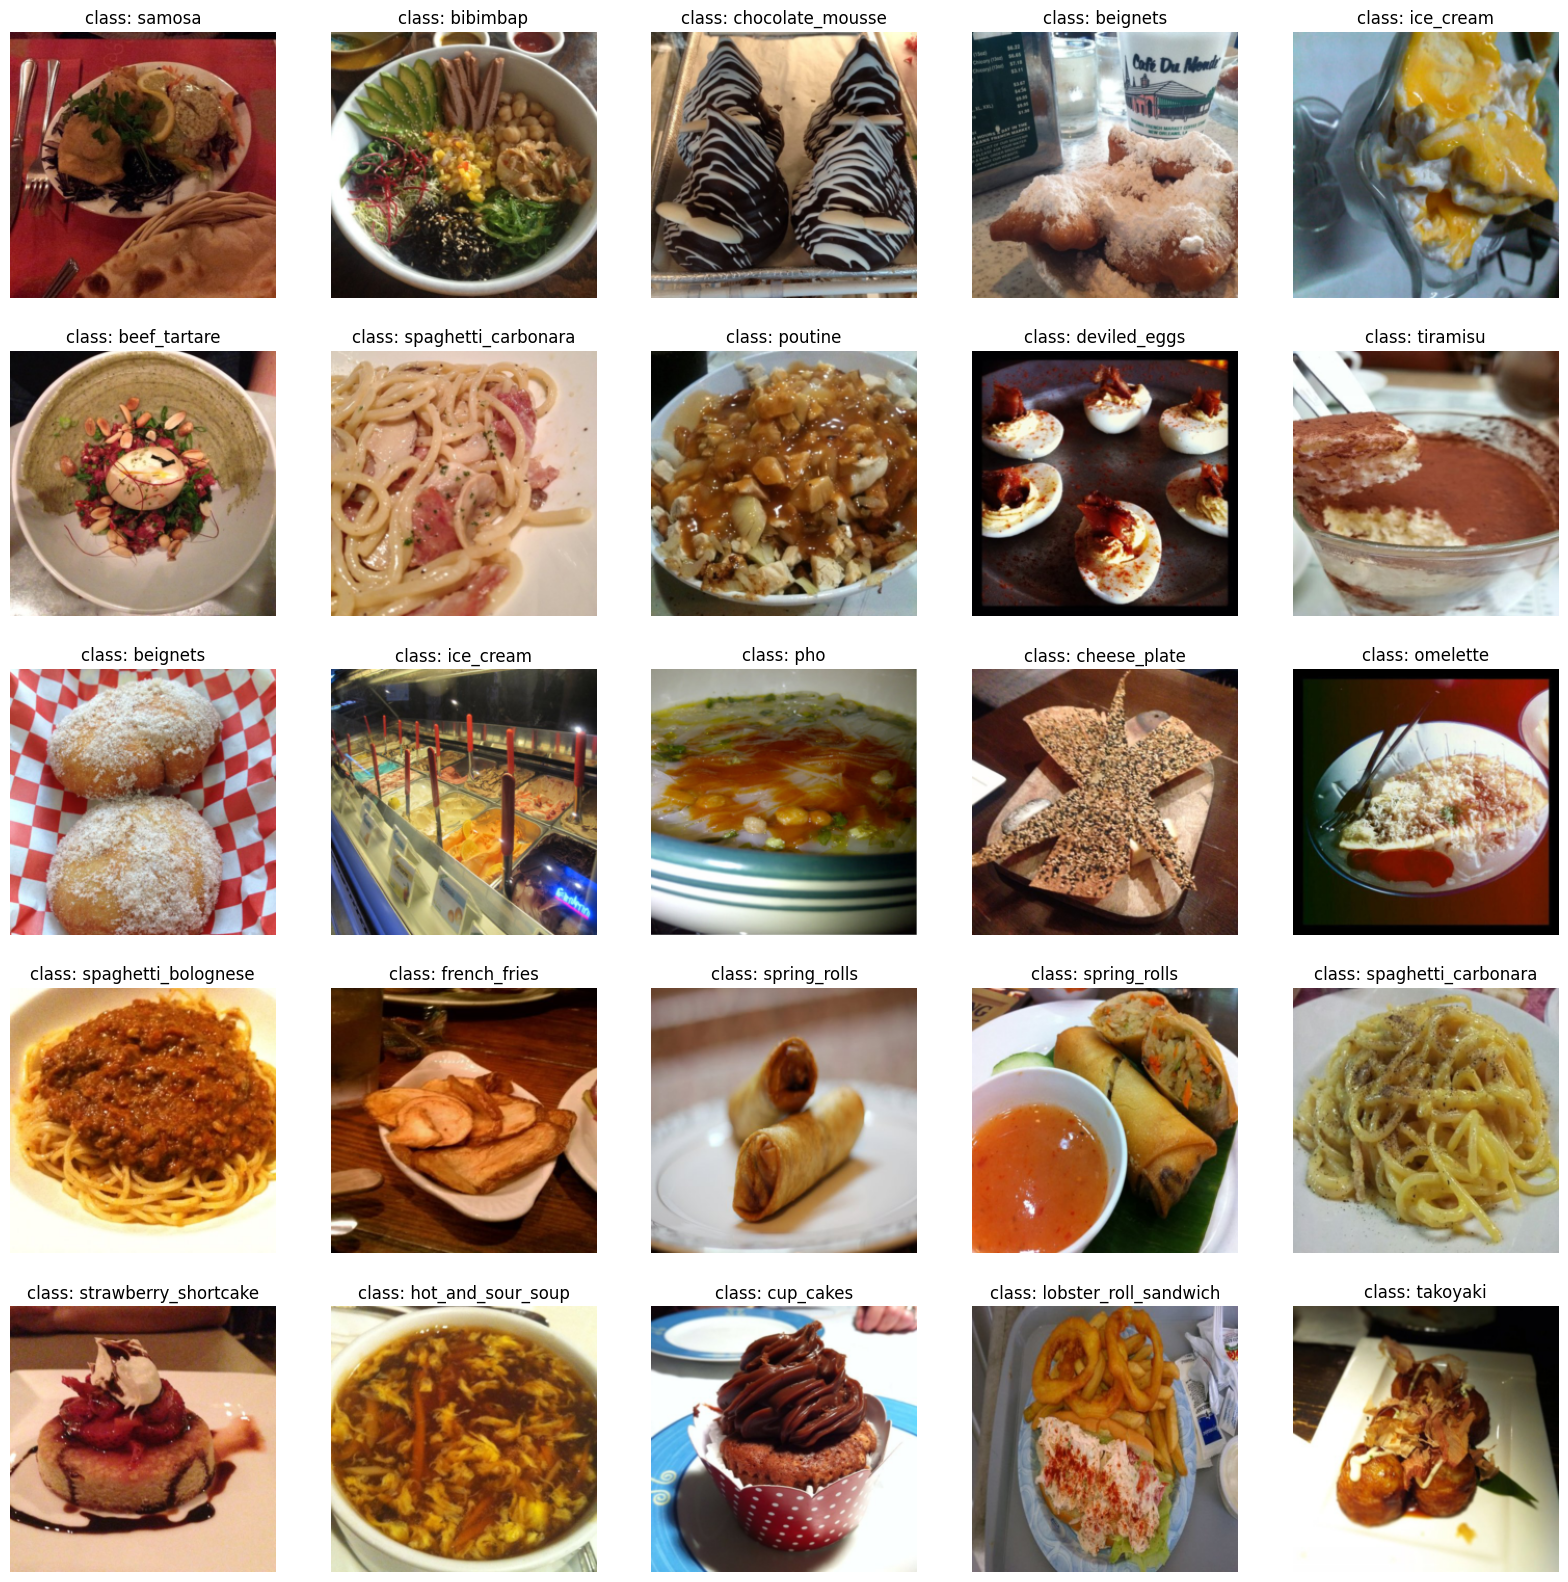

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's Swin Small Transformer

In [4]:
# Create transforms
IMG_SIZE_1 = 272
IMG_SIZE_2 = 256
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 16
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
swinb_model = torchvision.models.swin_v2_b(
    weights=torchvision.models.Swin_V2_B_Weights.DEFAULT,
    )

swinb_model.head = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)

# Compile model
swinb_model = torch.compile(swinb_model, backend="aot_eager")

# Print summary
summary(swinb_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0118 16:47:17.659000 24548 site-packages\torch\_dynamo\convert_frame.py:844] [5/256] torch._dynamo hit config.accumulated_cache_size_limit (256)
W0118 16:47:17.659000 24548 site-packages\torch\_dynamo\convert_frame.py:844] [5/256]    function: 'hook' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torchinfo\torchinfo.py:592)
W0118 16:47:17.659000 24548 site-packages\torch\_dynamo\convert_frame.py:844

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                            [16, 3, 256, 256]    [16, 101]            --                   True
├─SwinTransformer (_orig_mod)                                [16, 3, 256, 256]    [16, 101]            --                   True
│    └─Sequential (features)                                 [16, 3, 256, 256]    [16, 8, 8, 1024]     --                   True
│    │    └─Sequential (0)                                   [16, 3, 256, 256]    [16, 64, 64, 128]    6,528                True
│    │    └─Sequential (1)                                   [16, 64, 64, 128]    [16, 64, 64, 128]    403,720              True
│    │    └─PatchMergingV2 (2)                               [16, 64, 64, 128]    [16, 32, 32, 256]    131,584              True
│    │    └─Sequential (3)                                   [16, 32, 32, 256]    [16, 32, 3

Epoch: 10 | train_loss: 0.9869 | train_acc: 0.9449 | fpr_at_recall: 0.0010 | train_time: 38m41s | test_loss: 1.0372 | test_acc: 0.9198 | fpr_at_recall: 0.0024 | test_time: 5m36s | lr: 0.0000034227


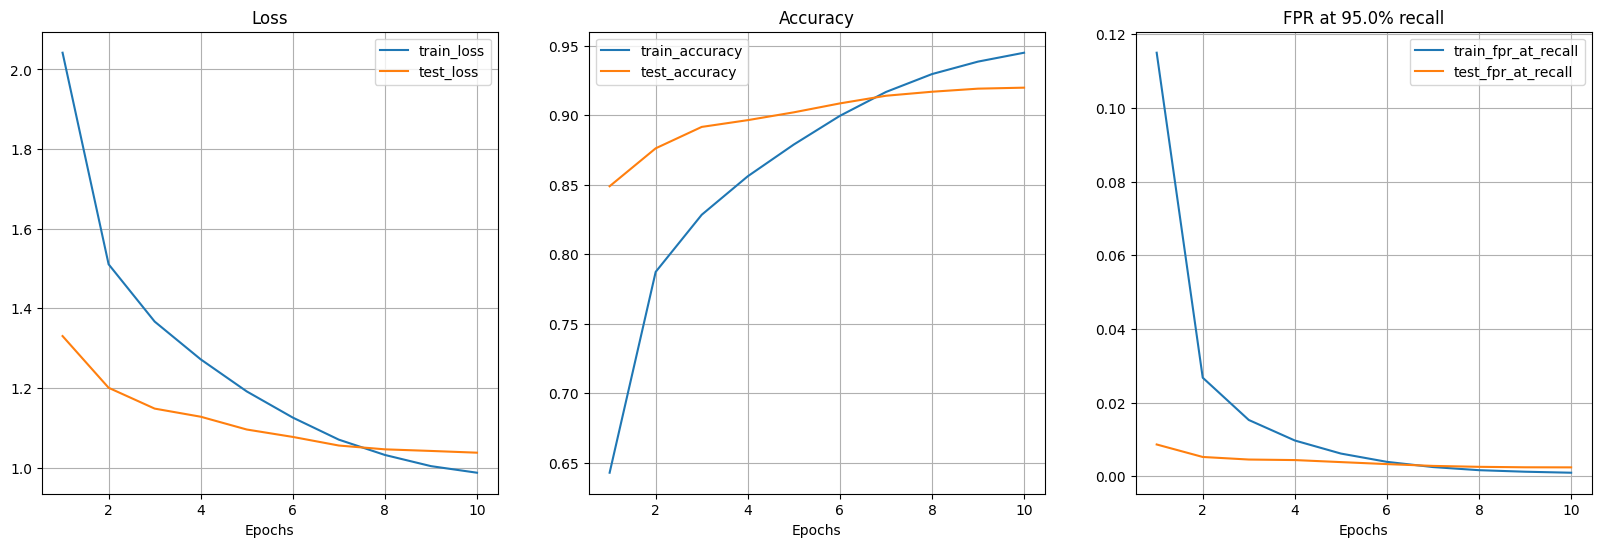

[INFO] Saving model to: ..\models\swinb_101_2025-01-16_loss.pth
[INFO] Saving model to: ..\models\swinb_101_2025-01-16_acc.pth
[INFO] Saving model to: ..\models\swinb_101_2025-01-16.pth


In [ ]:
# Train the model
model_type="swinb_101_2025-01-16"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
swinb_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=swinb_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=swinb_model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

swinb_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=swinb_model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4,
    )

In [ ]:
swinb_results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0      1    2.041897   0.642894             0.114982     2330.527193   
1      2    1.510450   0.787302             0.026759     2271.655912   
2      3    1.366547   0.828383             0.015279     2286.242224   
3      4    1.271639   0.856054             0.009707     2312.965180   
4      5    1.191092   0.878885             0.006163     2279.843962   
5      6    1.125374   0.899498             0.003912     2333.301921   
6      7    1.069926   0.916658             0.002497     2342.706653   
7      8    1.031505   0.929527             0.001649     2317.135618   
8      9    1.003434   0.938503             0.001233     2341.246624   
9     10    0.986894   0.944892             0.000960     2321.385335   

   test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0   1.330157  0.848876            0.008629     361.311990  0.000100  
1   1.200258  0.876148            0.005236     329.092049  0.000098  
2   1.147945  0.891545            0.004541     333.511352  0.000091  
3   1.127565  0.896414            0.004394     333.702853  0.000080  
4   1.095416  0.902035            0.003844     327.879499  0.000066  
5   1.076820  0.908447            0.003301     352.513170  0.000051  
6   1.055183  0.913949            0.002811     339.093357  0.000035  
7   1.045623  0.916838            0.002560     336.147734  0.000021  
8   1.041611  0.919055            0.002433     336.582034  0.000010  
9   1.037223  0.919767            0.002413     336.133252  0.000003

Epoch: 20 | train_loss: 0.8820 | train_acc: 0.9738 | fpr_at_recall: 0.0001 | train_time: 37m55s | test_loss: 1.0377 | test_acc: 0.9257 | fpr_at_recall: 0.0027 | test_time: 5m35s | lr: 0.0000016094


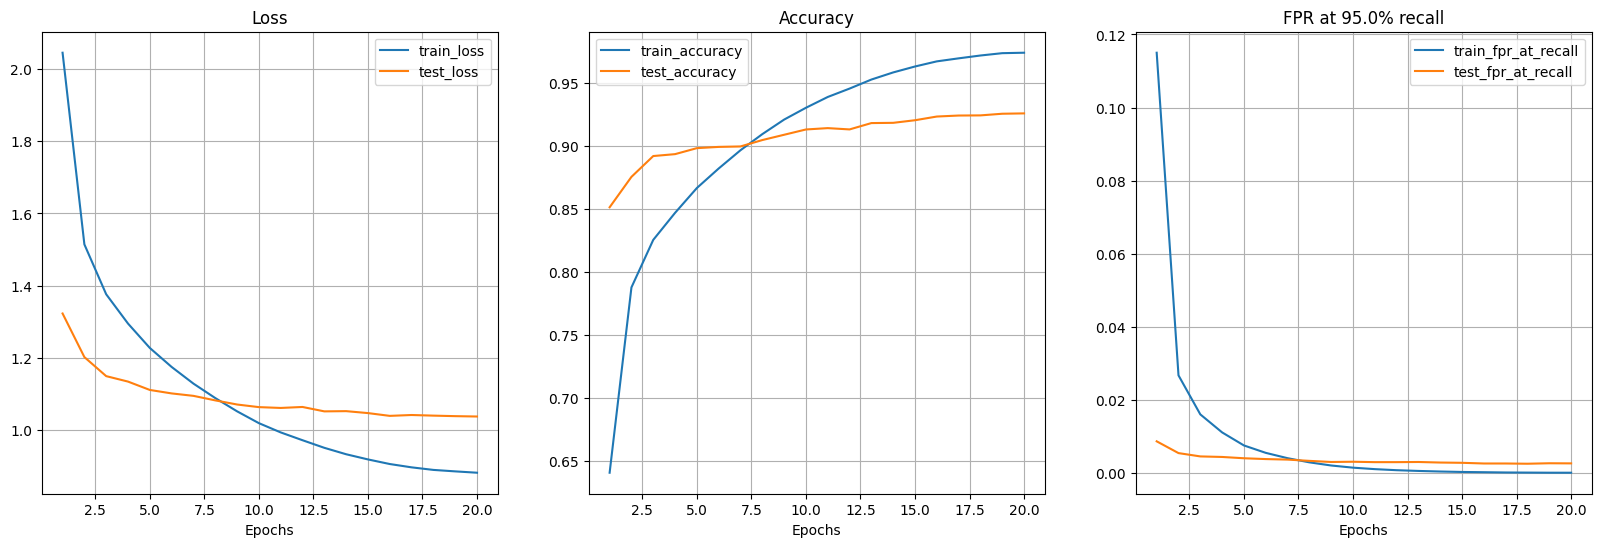

[INFO] Saving model to: ..\models\swinb_101_2025-01-17_loss.pth
[INFO] Saving model to: ..\models\swinb_101_2025-01-17_acc.pth
[INFO] Saving model to: ..\models\swinb_101_2025-01-17.pth


In [5]:
# Train the model
model_type="swinb_101_2025-01-17"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
swinb_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=swinb_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=swinb_model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

swinb_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=swinb_model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4,
    )

In [6]:
swinb_results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    2.044962   0.640963             0.114997     2314.709511   
1       2    1.514304   0.787821             0.026767     2246.089139   
2       3    1.376122   0.825506             0.016097     2279.756037   
3       4    1.295016   0.846924             0.011168     2252.312661   
4       5    1.227511   0.866609             0.007603     2248.859773   
5       6    1.174893   0.882075             0.005578     2243.873550   
6       7    1.128748   0.896542             0.004119     2248.657828   
7       8    1.088771   0.909306             0.002981     2250.478263   
8       9    1.052030   0.920829             0.002119     2253.815814   
9      10    1.019275   0.930201             0.001529     2251.896931   
10     11    0.993635   0.938754             0.001125     2253.765860   
11     12    0.972002   0.945407             0.000834     2250.767680   
12     13    0.950984   0.952561             0.000633     2251.705139   
13     14    0.933181   0.958210             0.000474     2249.327736   
14     15    0.918847   0.962909             0.000353     2250.685417   
15     16    0.906098   0.966975             0.000284     2262.452559   
16     17    0.896904   0.969368             0.000211     2255.318608   
17     18    0.889805   0.971621             0.000180     2278.891221   
18     19    0.885746   0.973469             0.000150     2267.353022   
19     20    0.882019   0.973825             0.000144     2275.902297   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0    1.322931  0.851330            0.008730     357.692302  0.000100  
1    1.202205  0.875435            0.005510     327.056751  0.000099  
2    1.149450  0.891941            0.004604     333.213637  0.000098  
3    1.134356  0.893445            0.004454     329.162100  0.000095  
4    1.111209  0.898195            0.004100     329.387451  0.000091  
5    1.101600  0.899185            0.003877     327.564445  0.000086  
6    1.094854  0.899541            0.003732     327.621532  0.000080  
7    1.082322  0.904607            0.003385     328.657554  0.000073  
8    1.070890  0.908803            0.003083     331.035157  0.000066  
9    1.063651  0.912999            0.003147     326.837368  0.000058  
10   1.061369  0.914067            0.003037     329.637990  0.000051  
11   1.064086  0.913038            0.003038     328.848455  0.000043  
12   1.051891  0.918065            0.003079     329.934116  0.000035  
13   1.052515  0.918263            0.002928     329.307197  0.000028  
14   1.047137  0.920321            0.002855     330.000563  0.000021  
15   1.039446  0.923250            0.002669     328.892308  0.000015  
16   1.041826  0.924042            0.002668     329.762234  0.000010  
17   1.040105  0.924161            0.002603     329.982468  0.000006  
18   1.038664  0.925467            0.002732     329.397464  0.000003  
19   1.037657  0.925744            0.002699     335.120091  0.000002